In [1]:
!pip uninstall https://test.pypi.org/simple/ simple-stein-svgd

Found existing installation: simple-stein-svgd 0.0.6
Uninstalling simple-stein-svgd-0.0.6:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/simple_stein_svgd-0.0.6.dist-info/*
    /usr/local/lib/python3.12/dist-packages/simple_stein_svgd/*
Proceed (Y/n)? Y
  Successfully uninstalled simple-stein-svgd-0.0.6


In [2]:
!pip install --extra-index-url https://pypi.org/simple/ -i https://test.pypi.org/simple/ simple-stein-svgd

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from simple_stein_svgd import SVGD

In [4]:
def logsumexp(a, axis=None):
    a_max = np.max(a, axis=axis, keepdims=True)
    return np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True)) + a_max

def log_prob_2d_mog(x):
    # x: (n, 2)
    # mixture of two 2D gaussians
    means = np.stack([
        np.array([2.0, 2.0]),
        np.array([-2.0, -2.0]),
    ], axis=0)  # (2,2)

    cov = np.eye(2)
    inv_cov = np.linalg.inv(cov)
    log_norm = -0.5 * np.log((2 * np.pi)**2 * np.linalg.det(cov))

    # compute component log-probs
    diffs = x[:, None, :] - means[None, :, :]  # (n,2,2)-> actually (n, K, d)
    quad = np.einsum('nkd,dd,nkd->nk', diffs, inv_cov, diffs)  # (n,K)
    comps = log_norm - 0.5 * quad  # (n,K)

    # equal mixture weights
    lse = logsumexp(comps, axis=1)  # (n,1)
    return (lse - np.log(2)).reshape(-1)


In [5]:
np.random.seed(7)
n, d = 256, 2
particles = np.random.randn(n, d) * 3.0  # spread out
svgd = SVGD(log_prob_2d_mog)

T = 200
stepsize = 0.05

ksd_hist = []
time_hist = []

for t in range(T):
    res = svgd.update(particles, stepsize=stepsize)
    particles = res.particles
    ksd_hist.append(res.ksd)
    time_hist.append(res.wall_time)

    if (t + 1) % 20 == 0:
        print(f"iter {t+1:3d} | KSD={res.ksd:.6f} | wall={res.wall_time*1e3:.2f} ms")


iter  20 | KSD=0.629525 | wall=722.56 ms
iter  40 | KSD=0.558121 | wall=745.84 ms
iter  60 | KSD=0.496101 | wall=730.69 ms
iter  80 | KSD=0.440767 | wall=883.41 ms
iter 100 | KSD=0.390138 | wall=710.35 ms
iter 120 | KSD=0.343373 | wall=1355.86 ms
iter 140 | KSD=0.303957 | wall=724.52 ms
iter 160 | KSD=0.277405 | wall=726.66 ms
iter 180 | KSD=0.269569 | wall=868.07 ms
iter 200 | KSD=0.281591 | wall=729.40 ms


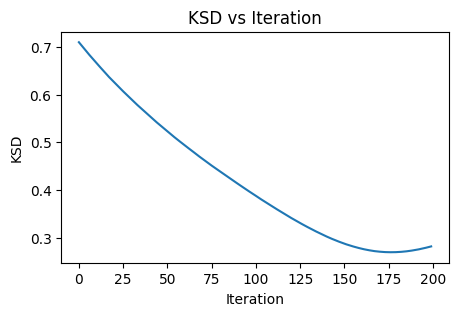

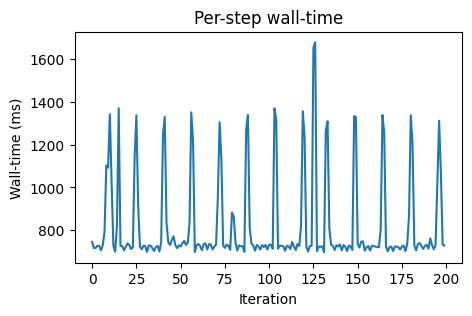

In [6]:
plt.figure(figsize=(5,3))
plt.plot(ksd_hist)
plt.xlabel("Iteration")
plt.ylabel("KSD")
plt.title("KSD vs Iteration")
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.array(time_hist) * 1e3)
plt.xlabel("Iteration")
plt.ylabel("Wall-time (ms)")
plt.title("Per-step wall-time")
plt.show()


In [7]:
print("Final mean:", particles.mean(axis=0))
print("Final covariance:\n", np.cov(particles.T))

Final mean: [-0.18134934 -0.34247604]
Final covariance:
 [[6.42515783 2.37218321]
 [2.37218321 5.85692585]]
